In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5" #! specify gpu here
import cv2
from PIL import Image as PILImage
from rich import print as richprint
import json
import textwrap
from pathlib import Path

from object_reid import ObjectReId
from vision_pipeline.helpers import Struct, scale_img, img_row
from vision_pipeline.knowledge_tree.knowledge_tree import KnowledgeTree
from vision_pipeline.llm_data_generator.labelme_importer import LabelMeImporter

from context_action_framework.types import Detection, Label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
labelme_importer = LabelMeImporter()

config:
{
    'node_name': 'vision',
    'reid': False,
    'basler': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 180,
        'topic': 'basler',
        'camera_node': '/basler',
        'image_topic': 'image_rect_color',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_graph_img': True,
        'has_depth': False,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'table_name': 'table_vision',
        'parent_frame': 'vision_table_zero',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'work_surface_ignore_border_width': 50,
        'show_work_surface_detection': False,
        'use_worksurface_detection': True,
        'debug_work_surface_detection': False
    },
    'realsense': {
        'target_fps': 10,
        'max_allowed_acquisition_delay': 1.0,
        'rotate_img': 0,
        'topic': 'realsense',
        'camera_node': '/realsense',
        'image_topic': 'color/image_raw',
        'info_topic': 'color/camera_info',
        'depth_topic': 'aligned_depth_to_color/image_raw',
        'sleep_camera_on_exit': False,
        'publish_labelled_img': True,
        'publish_depth_img': True,
        'publish_cluster_img': True,
        'publish_graph_img': False,
        'has_depth': True,
        'compute_gaps': True,
        'run_continuous': True,
        'wait_for_services': False,
        'detect_arucos': False,
        'camera_height': 0.2,
        'parent_frame': 'panda_2/realsense',
        'create_parent_frame': True,
        'marker_lifetime': 1,
        'calibration_file': '~/vision_pipeline/realsense_calib/realsense_calib.yaml',
        'debug_clustering': False
    },
    'obj_detection': {
        'debug': True,
        'model': 'yolov8',
        'yolact_dataset_file': '~/vision_pipeline/data_limited/yolact/2023-07-18_firealarms_hcas/dataset.json',
        'yolact_score_threshold': 0.5,
        'yolov8_model_file': 
'~/vision_pipeline/data_limited/yolov8/output_2024-07-17_20000_incl_new_jsi_imgs_p2/epoch60.pt',
        'yolov8_score_threshold': 0.5,
        'superglue_templates': '~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped',
        'superglue_model_file': 
'~/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt',
        'superglue_match_threshold': 0.5,
        'rotation_median_filter': False,
        'superglue_visualise_to_file': False,
        'classifier_model_file': 
'~/vision_pipeline/data_limited/classifier/2024-07-19__14-32_classify/lightning_logs/version_0/checkpoints/epoch=33
9-step=339.ckpt',
        'classifier_threshold': 0.2
    }
}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.learning_rate 1e-05

model.batch_size 64

model.freeze_backbone False

curr_weights_path 
/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt

Loaded SuperPoint model
Loaded SuperGlue model ("/home/docker/superglue_training/output/train/2024-06-26_superglue_model_evens_finished/weights/best.pt" weights)


100%|██████████| 61/61 [00:01<00:00, 47.53it/s]


Loaded superglue templates 61

In [4]:
kt = KnowledgeTree()
kt.load_knowledge_tree()
kt.print_knowledge_tree()

kt.load_CLIP()

kg_nodes_path /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes

found camera info: /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/kalo/4_camera_info.pickle

device
├── hca
│   ├── kalo
│   │   ├── kalo_1
│   │   ├── kalo_2
│   │   ├── kalo_3
│   │   ├── kalo_4
│   │   ├── kalo_5
│   │   ├── kalo_6
│   │   ├── kalo_crop_back
│   │   └── kalo_crop_front
│   └── qundis
│       ├── qundis_1
│       ├── qundis_2
│       ├── qundis_3
│       ├── qundis_4
│       ├── qundis_5
│       ├── qundis_5_1
│       ├── qundis_5_2
│       ├── qundis_6
│       ├── qundis_6_1
│       ├── qundis_crop_back
│       └── qundis_crop_front
└── smoke_detector
    ├── fumonic
    │   ├── fumonic_1
    │   ├── fumonic_2
    │   ├── fumonic_3
    │   ├── fumonic_4
    │   ├── fumonic_crop_back
    │   └── fumonic_crop_front
    ├── hekatron
    │   ├── hekatron_1
    │   ├── hekatron_2
    │   ├── hekatron_3
    │   ├── hekatron_4
    │   ├── hekatron_5
    │   ├── hekatron_6
    │   ├── hekatron_crop_back
    │   └── hekatron_crop_front
    └── kaloremotus

self.device cuda

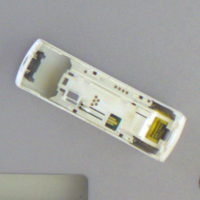

imgs_encoding.shape
torch.Size([22, 512])

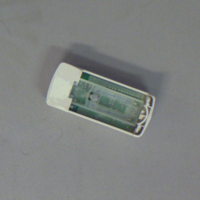

qundis_2 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/qundis/2_qa.json


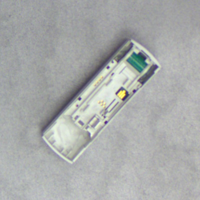

kalo_2 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/kalo/2_qa.json


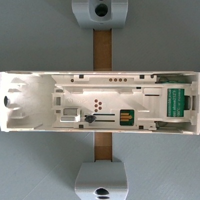

kalo_4 /home/docker/datasets2/reconcycle/knowledge_graph/data/nodes/kalo/4_qa.json


In [5]:
#! EXAMPLE:

# query_img_crop_img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped/firealarm_back_10/00_template_0068.jpg")
query_img_crop_img_path = os.path.expanduser("~/datasets2/reconcycle/2023-12-04_hcas_fire_alarms_sorted_cropped/hca_back_03/0006.jpg")

query_crop_img = PILImage.open(query_img_crop_img_path)

# display(Image.fromarray(scale_img(cv2.cvtColor(query_crop_img, cv2.COLOR_BGR2RGB))))
display(query_crop_img.resize((200, 200)))

topk_keys = kt.get_nearest_neighbour(query_crop_img, k=3)

for topk_key in topk_keys:

    device_data = kt.devices_data[topk_key]
    display(device_data.crop_img.resize((200, 200)))

    topk_i = kt.devices_data[topk_key]
    # print("top:", topk_key, topk_i)

    print(topk_key, device_data.qa_json_path)


In [28]:
objective = textwrap.dedent("""You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.\n""")

available_tools = textwrap.dedent("""
Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. \n""")

def get_example_texts(topk_keys):

    # now get the example texts
    examples_text = ""
    for idx, topk_key in enumerate(topk_keys):
        device_data = kt.devices_data[topk_key]
        with open(device_data.qa_json_path) as f:
            QAs = json.load(f)
            # print(QAs)
            examples_text += f"Example {idx+1}:\n"
            
            for qa in QAs:
                examples_text += f"Q: {qa['Q']}\n"
                if isinstance(qa['A'], dict):
                    # print("DICT!")
                    examples_text += "A: {\n"
                    for key, value in qa['A'].items():
                        examples_text += f"{key}: {value}\n"
                    examples_text += "}\n"
                else:
                    examples_text += f"A: {qa['A']}\n"
            
            examples_text += "\n"

    return examples_text


In [29]:
def get_query_text(detections, graph_relations, module=None):

    A_relations = graph_relations.to_text()

    
    # include the module name in the relations
    if module is not None:
        richprint("module", module.name)
        A_relations = f"at_location(table_{module.name}). " + A_relations
    else:
        richprint("[red]Missing module name!")
    
    positions_list = []
    for detection in detections:
        text = f"{detection.label.name}"
        if detection.label_face is not None:
            text += f" {detection.label_face.name}"
        
        # todo: better label names
        # if detection.label_precise is not None:
        #     label_id = detection.label_precise.split("_")[-1]
        #     text += f" (id: {label_id})"

        if detection.label_precise_name is not None:
            text += f" ({detection.label_precise_name})"
    
        text += f" at ({detection.center_px[0]}, {detection.center_px[1]})"
        positions_list.append(text)


    
    A_positions = ", ".join(positions_list) + ". "

    # print("A_positions:", A_positions)

    query_text = '''End of examples. You are given these facts about a query:\n'''
    
    
    # query_text += "Q: Where is the device?\n"
    # query_text += f"A: \n\n"

    query_text += "Q: What are the object relations?\n"
    query_text += f"A: {A_relations}\n\n"

    query_text += "Q: What are the object positions?\n"
    query_text += f"A: {A_positions}\n\n"

    query_text += textwrap.dedent("""
    Q: What is the JSON formatted disassembly step? Use the format:
    {
    reasoning: [explain you reasoning for tool choice],
    tool: [tool name],
    tool_arguments: [arguments to tool function]\n""")
    if module is not None:
        query_text += f"current_module: {module.name}\n"
    query_text += textwrap.dedent("""new_module: [the new module the device is on after performing the action]\n}""")
    # print(query_text)
    return query_text

resetting worksurface detection

Converting 1:   0%|          | 0/5 [00:00<?, ?it/s]

filename 1.json

running worksurface detection...

camera: basler

classify: kalo2, 01, conf: 1.00

elapsed_time_classify_and_rot 0.031185709172859788

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/1.jpg
len(batch_crop_imgs) 1


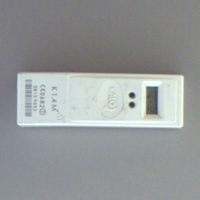

imgs_encoding.shape
torch.Size([22, 512])

topk_keys ['kalo_2' 'kalo_1' 'qundis_2']

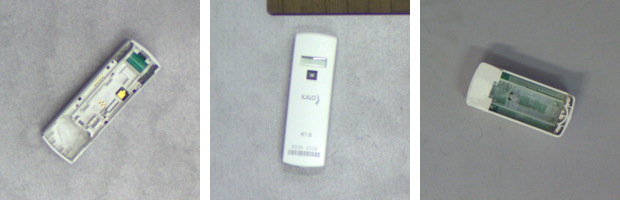

module vision

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.


Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. 

Example 1:
Q: What are the object r

resetting worksurface detection

Converting 2:  20%|██        | 1/5 [00:00<00:01,  3.02it/s]

filename 2.json

running worksurface detection...

camera: basler

classify: kalo2, 01, conf: 0.99

elapsed_time_classify_and_rot 0.045426102820783854

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/2.jpg
len(batch_crop_imgs) 1


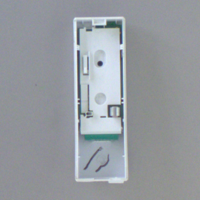

imgs_encoding.shape
torch.Size([22, 512])

topk_keys ['kalo_2' 'kalo_4' 'qundis_2']

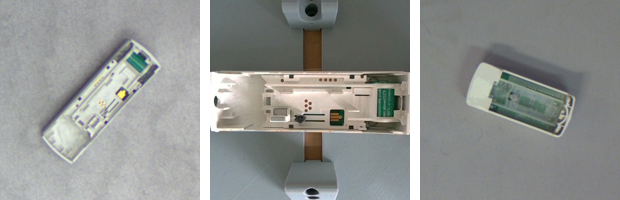

module vision

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.


Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. 

Example 1:
Q: What are the object r

resetting worksurface detection

Converting 3:  40%|████      | 2/5 [00:00<00:01,  2.56it/s]

filename 3.json

found camera info: /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/3_camera_info.pickle

camera: realsense

classify: kalo2, 01, conf: 0.87

elapsed_time_classify_and_rot 0.028865351108834147

trying again with dilated mask!

 no depth info! gap

trying again with dilated mask!

 no depth info! hca

trying again with dilated mask!

 no depth info! battery

trying again with dilated mask!

 no depth info! internals

/home/docker/vision_pipeline/gap_detection/gap_detector_clustering.py:153: UserWarning: Warning: converting a masked element to nan.
  depth_list[count] = np.array([i, j, mask[i, j]])


gaps None

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/3.jpg
len(batch_crop_imgs) 1


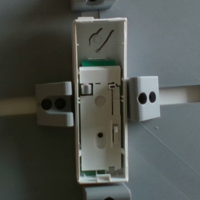

imgs_encoding.shape
torch.Size([22, 512])

topk_keys ['kalo_4' 'qundis_3' 'fumonic_3']

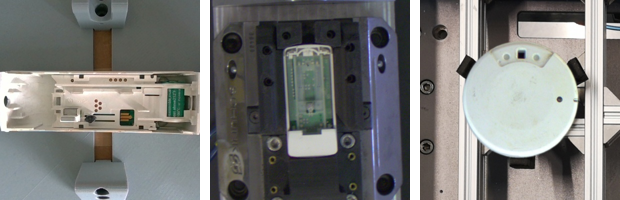

module vise

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.


Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. 

Example 1:
Q: What are the object r

resetting worksurface detection

Converting 4:  60%|██████    | 3/5 [00:04<00:04,  2.06s/it]

filename 4.json

running worksurface detection...

camera: basler

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/4.jpg
len(batch_crop_imgs) 0
Label.battery None None
Label.pcb None None
Label.internals None None
Label.hca_empty LabelFace.back None


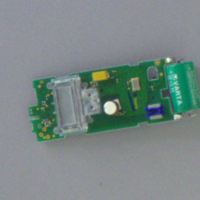

imgs_encoding.shape
torch.Size([22, 512])

topk_keys ['qundis_2' 'qundis_4' 'qundis_3']

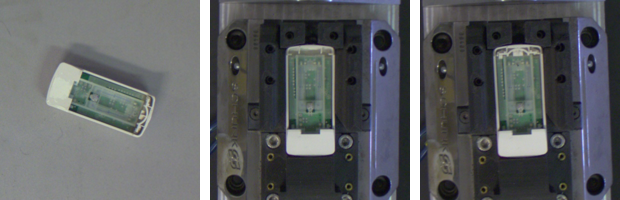

module vise

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.


Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. 

Example 1:
Q: What are the object r

resetting worksurface detection

Converting 5:  80%|████████  | 4/5 [00:05<00:01,  1.36s/it]

filename 5.json

running worksurface detection...

camera: basler

img_path /home/docker/datasets2/reconcycle/knowledge_tree_tests/kalo2/5.jpg
len(batch_crop_imgs) 0
Label.pcb None None
Label.internals None None
Label.hca_empty LabelFace.back None
Label.battery None None


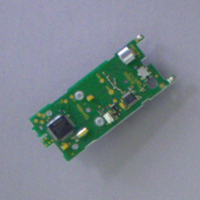

imgs_encoding.shape
torch.Size([22, 512])

topk_keys ['qundis_4' 'kalo_3' 'qundis_2']

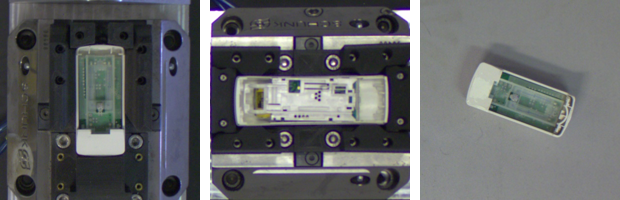

module cutter

You are an agent controlling a robotic workcell.
Objective:
Disassemble visible electronic devices to separate out the batteries for recycling. To do this, provide reasoning, select a tool and tool argument, i.e. predict the disassembly action.


Available tools:
pick_and_place: pick up an object from the work surface and place somewhere. For example a device can be picked up and put in the vise for levering.
lever: given a gap, lever out internal components of a device. The module must be vise to use this tool.
cut: given a device, cut it in two pieces.
cnc_mill: mill out the top of a device to reveal the insides.
screwdriver: unscrew a screw from a device.

Background information:
If the module is vision you can perform pick_and_place.
If the module is vise you can perform lever, and pick_and_place, and cut. Lever can only be used when the device is on the vise module. The battery can be cut from the PCB if it is has been removed from the device. 

Example 1:
Q: What are the object r

resetting worksurface detection

Converting 5: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


In [30]:
# print("kt.devices_data", kt.devices_data)
folder = Path("~/datasets2/reconcycle/knowledge_tree_tests/kalo2").expanduser()

for img_path, colour_img, detections, graph_relations, module, camera, batch_crop_imgs in labelme_importer.process_labelme_dir(folder, use_yield=True):

    print("img_path", img_path)
    print("len(batch_crop_imgs)", len(batch_crop_imgs))

    if len(batch_crop_imgs) == 0:

        for detection in detections:
            print(detection.label, detection.label_face, detection.label_precise)
    #     # TODO: try and find other stuff in image to crop

        # for group in graph_relations.groups:
            # get PCB or battery
            # for detection in group:
        
        # if no hca or smoke detector to crop, look for PCB            
        for idx, detection in enumerate(detections):
            if detection.label in [Label.pcb]: #! LOOK FOR PCB

                crop_size = int(detection.edge_px_large*1.4) #crop such that 80% of the image is the device
                sample_crop, _ = ObjectReId.crop_det(colour_img, detection, size=crop_size)
                # sample_crop = imutils.resize(sample_crop, width=400, height=400) # set size to 400x400
                sample_crop = cv2.resize(sample_crop, (400, 400), interpolation=cv2.INTER_AREA)

                batch_crop_imgs.append(sample_crop) #! here we add it

                # sample_crop = PILImage.fromarray(cv2.cvtColor(sample_crop, cv2.COLOR_BGR2RGB))
                # display(sample_crop.resize((200, 200)))


    if len(batch_crop_imgs) > 0:
        batch_crop_img = PILImage.fromarray(cv2.cvtColor(batch_crop_imgs[0], cv2.COLOR_BGR2RGB))

        display(batch_crop_img.resize((200, 200)))

        topk_keys = kt.get_nearest_neighbour(batch_crop_img, k=3)

        richprint("topk_keys", topk_keys)

        imgs = [kt.devices_data[topk_key].crop_img.resize((200, 200)) for topk_key in topk_keys]

        row_of_imgs = img_row(imgs)
        display(row_of_imgs)
        
        # for topk_key in topk_keys:
        #     device_data = kt.devices_data[topk_key].crop_img
        #     # imgs.append(device_data.crop_img)
        #     display(device_data.crop_img.resize((200, 200)))


        # total_width = sum([img.size[0] for img in imgs])
        # max_height = max([img.size[1] for img in imgs])
        # new_image = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))

        # past_width = 0
        # for idx, img in enumerate(imgs):
        #     new_image.paste(img, (past_width, 0))
        #     past_width += img.size[0]
        #     # new_image.paste(image2, (width1, 0))
        #     # new_image.paste(image3, (width1 + width2, 0))

        # display(new_image)


        example_texts = get_example_texts(topk_keys)

        query_texts = get_query_text(detections, graph_relations, module)

        print(objective)
        print(available_tools)
        print(example_texts)
        print(query_texts)


    # break #! DEBUG
    